# CS4035 - Cyber Data Analytics
## Lab 2 LOF - ARMA
### Group 33 - Martijn van Meerten 4387902

In [391]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("lab2_LOF_ARMA.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 593


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.neighbors import LocalOutlierFactor

## Pre-processing

In [93]:
df = pd.read_csv('SWaT_train.csv', skipinitialspace=True)
df.drop(columns=["Timestamp", "Normal/Attack"], inplace=True)
df = df[30000:]
X = df.to_numpy()

In [110]:
df_test = pd.read_csv('SWaT_test.csv')
df_test.loc[df_test['Normal/Attack'] == 'Attack', 'Normal/Attack'] = 1 # Attack
df_test.loc[df_test['Normal/Attack'] == 'Normal', 'Normal/Attack'] = 0 # Normal
y = df_test['Normal/Attack'].to_numpy().astype(int)
df_test.drop(columns=["Unnamed: 0", " Timestamp", "Normal/Attack"], inplace=True)

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

Plot LOF scores over time series

In [301]:
np.random.seed(42)

# Take a slice of 50000 from the training data to reduce computation time.
X_50000 = X[50000:100000]
negative_outlier_factors = []
predictions = []

for n_neighbors in range(15, 45, 5):
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, metric='cosine')
    y_pred = clf.fit_predict(X_50000)
    negative_outlier_factors.append(clf.negative_outlier_factor_ * -1)
    predictions.append(y_pred)

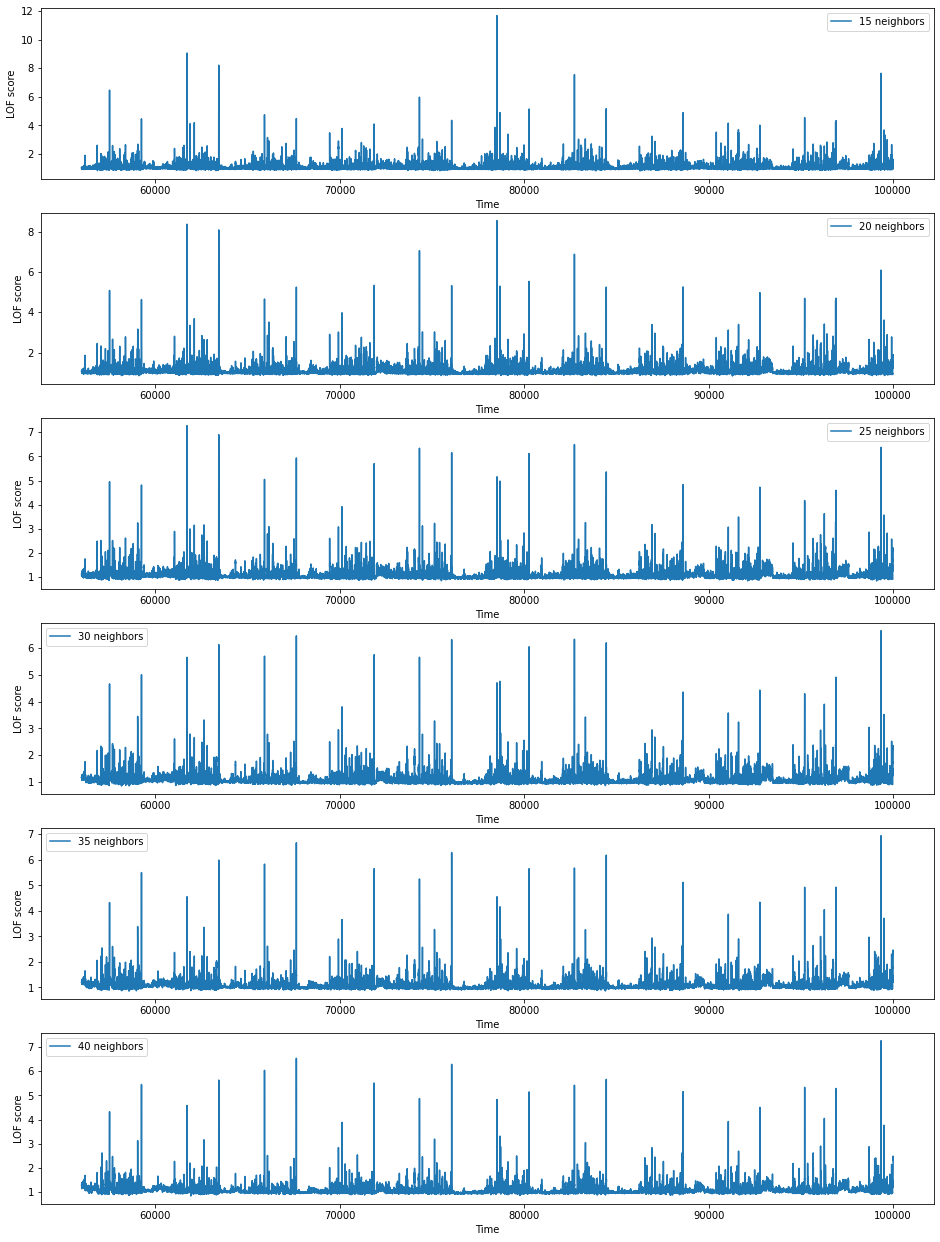

In [344]:
fig, ax = plt.subplots(len(negative_outlier_factors))
fig.set_figheight(22)
fig.set_figwidth(16)

def label(k):
    return '{} neighbors'.format(k)

# For each k plot the LOF score for the data points.
for i in range(len(negative_outlier_factors)):
    ax[i].plot(range(56000, 100000), negative_outlier_factors[i][6000:], label=label(range(15, 50, 5)[i]))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('LOF score')
    ax[i].legend()

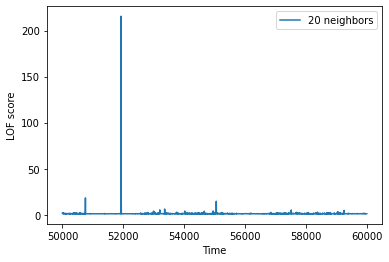

In [347]:
fig, ax = plt.subplots()
ax.plot(range(50000, 60000), negative_outlier_factors[1][:10000], label=label(20))
ax.set_xlabel('Time')
ax.set_ylabel('LOF score')
ax.legend();

Here we calculate the difference in average distances between the abnormality points and its 20 neighbors.

In [387]:
# The index of the abnormality
i = np.argmax(negative_outlier_factors[1])
clf = LocalOutlierFactor(n_neighbors=20, metric='cosine')
clf = clf.fit(X_50000)
# The distances to and indices of its 20 closest neighbors
distances = clf.kneighbors(X_50000[i].reshape(1, -1))
# The distances of the 20 neighbors to their 20 closest neighbors
neighbors_distances = clf.kneighbors(X_50000[distances[1][0]])
averages = []
# Collect the averages of the 20 neighbor's distances
for neighbor_distance in neighbors_distances[0][1:]:
    averages.append(np.average(neighbor_distance))

# The ratio between the average distances
ratio = np.average(distances[0][0]) / np.average(averages)
ratio

14.756974266455629

### 2b. Analysis and answers to the questions

1. Cosine distance is used for the distance metric. Due to the high dimensionality of the data, distance metrics like euclidian distance perform worse, because of large distances between relatively similar points.
2. The LOF scores for different sizes of k neighbors do not differ too much from each other. Minimizing k is beneficial in terms of the complexity of the algorithm. The plot for k=15 shows relatively more differences to the other plots, therefore k=20 is chosen. 
3. There is a large abnormality at time 51929 with an LOF score of 215.6. There are other abnormalities in the 50000 data points, but they are significantly lower. This is because of the difference in distances between the abnornamality and its neighbors as shown above and can be considered a point anomaly, potentially due to a sensor glitch.
4. LOF is suited for point-based anomaly detection. It is able detect a row with an unusual combination of features. It is not suited for contextual anomaly detection or collective anomly detection, due to the fact that LOF looks at neighbors irrespective of the time associated with that neighbor.

## 4. ARMA task – 1/2 A4 - Individual

### 4a. Print relevant plots and/or metrics to determine the parameters.

We plot the ACF and PACF plots for five different signals. From these plots we will determine the orders of the ARMA models.

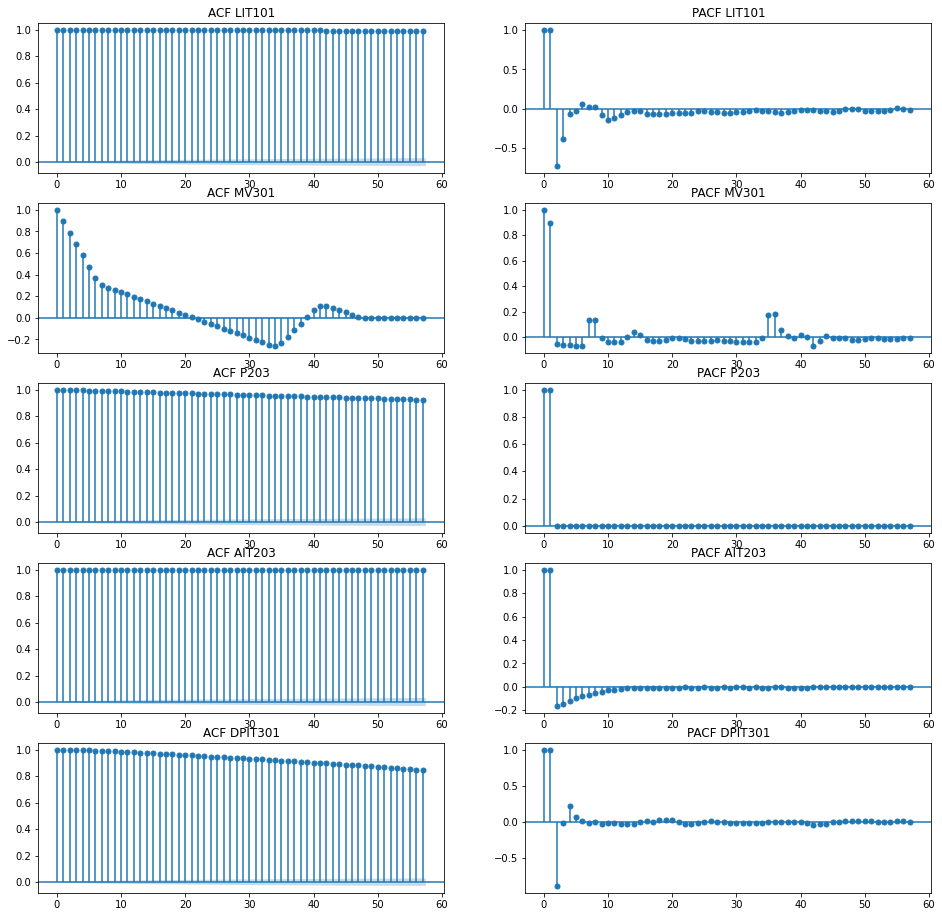

In [89]:
### WARNING: Running this cell takes roughly 10 minutes ###
fig, ax = plt.subplots(5, 2)
fig.set_figheight(16)
fig.set_figwidth(16)

# Plot the ACF and PACF plots for five different signals
plot_acf(df['LIT101'], ax=ax[0][0], title="ACF LIT101");
plot_acf(df['MV301'], ax=ax[1][0], title="ACF MV301");
plot_acf(df['P203'], ax=ax[2][0], title="ACF P203");
plot_acf(df['AIT203'], ax=ax[3][0], title="ACF AIT203");
plot_acf(df['DPIT301'], ax=ax[4][0], title="ACF DPIT301");
plot_pacf(df['LIT101'], ax=ax[0][1], title="PACF LIT101");
plot_pacf(df['MV301'], ax=ax[1][1], title="PACF MV301");
plot_pacf(df['P203'], ax=ax[2][1], title="PACF P203");
plot_pacf(df['AIT203'], ax=ax[3][1], title="PACF AIT203");
plot_pacf(df['DPIT301'], ax=ax[4][1], title="PACF DPIT301");

A slowly decreasing or constant **ACF** and a sudden cut-off for **PACF** indicate an **AR** model, where the order is determined by the lag at which the cut-off happens. All signals exhibit this behavior. Therefore,
- LIT101: AR(4)
- MV301: AR(2)
- P203: AR(2)
- AIT203: AR(2)
- DPIT301: AR(3)

In [156]:
# Train models
LIT101 = ARIMA(df['LIT101'], order=(4, 0, 0)).fit()
print('LIT101 AR(4) = {}'.format(LIT101.aic))
P203 = ARIMA(df['P203'], order=(2, 0, 0)).fit()
print('P203 AR(2) = {}'.format(P203.aic))
AIT203 = ARIMA(df['AIT203'], order=(2, 0, 0)).fit()
print('AIT203 AR(2) = {}'.format(AIT203.aic))
DPIT301 = ARIMA(df['DPIT301'], order=(3, 0, 0)).fit()
print('DPIT301 AR(3) = {}'.format(LIT101.aic))
MV301 = ARIMA(df['MV301'], order=(2, 0, 0)).fit()
print('MV301 AR(2) = {}'.format(MV301.aic))

LIT101 AR(4) = 223549.42728576326
P203 AR(2) = -2222474.7427533874
AIT203 AR(2) = -1112030.0349620257
DPIT301 AR(3) = 223549.42728576326
MV301 AR(2) = -1493645.239555052


c:\users\martijn.vanmeerten\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\martijn.vanmeerten\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MV301 ARMA(2, 1) = -1492712.9738381014


### 4b. Plots to study the detected anomalies

Below, the fitted models are evaluated on the test data. The residuals are plotted for the training data and the test data. Red points on the test data indicate attacks and the value of the residual for that attack.

In [208]:
LIT101_test = LIT101.apply(df_test['LIT101'])
P203_test = P203.apply(df_test['P203'])
AIT203_test = AIT203.apply(df_test['AIT203'])
DPIT301_test = DPIT301.apply(df_test['DPIT301'])
MV301_test = MV301.apply(df_test['MV301'])

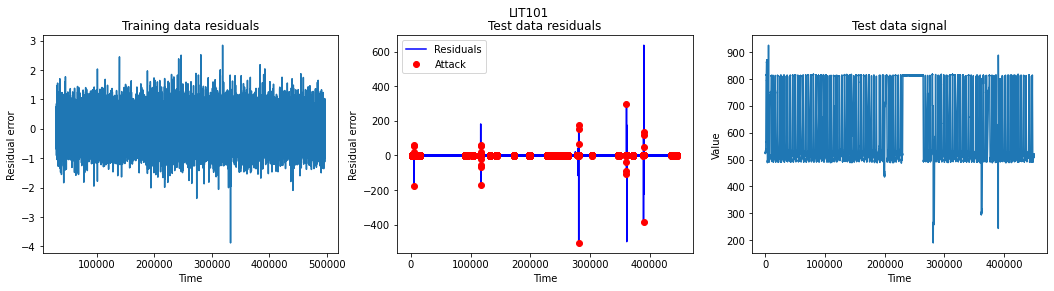

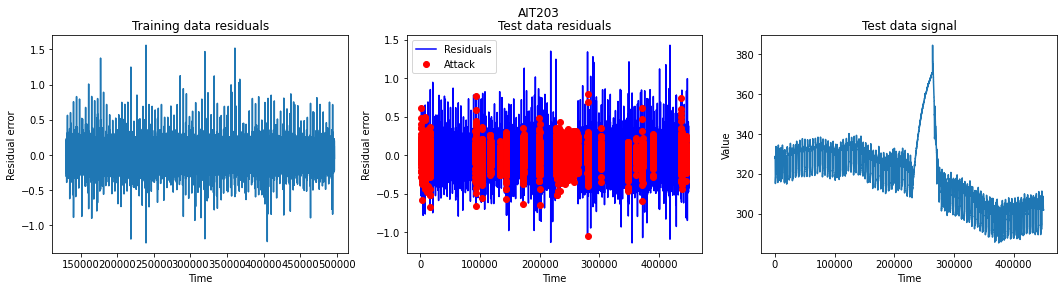

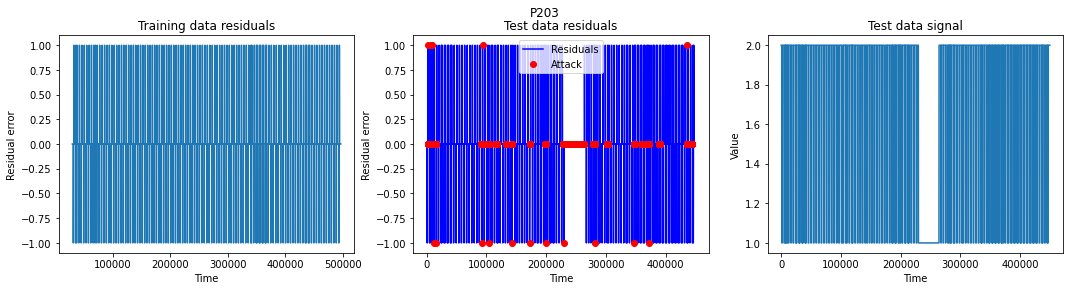

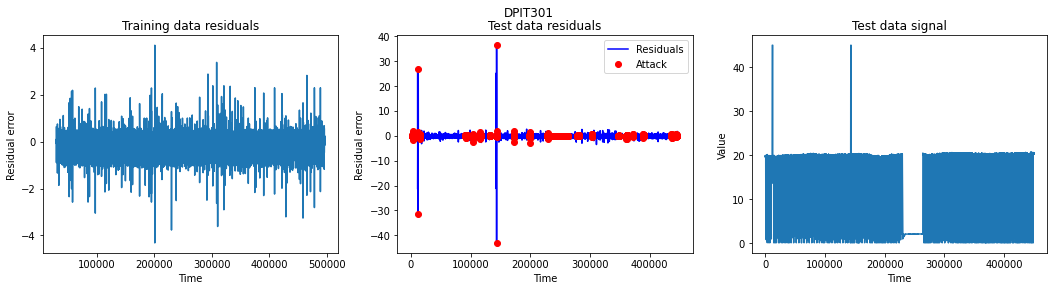

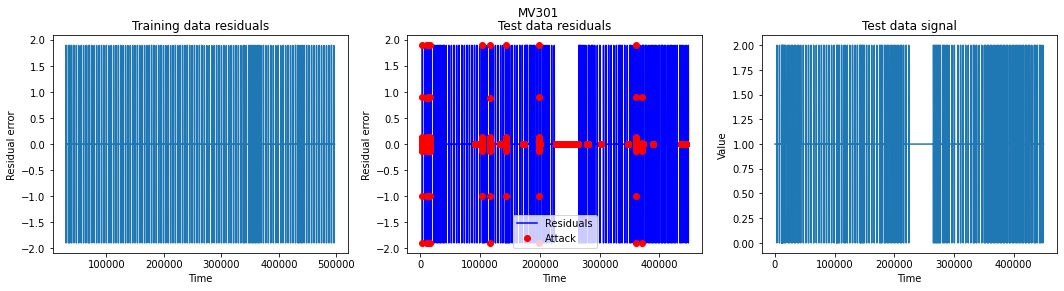

In [262]:
def plot_residuals(training_results, test_results, test_signal, y, title='Residuals of signal'):
    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(18)
    fig.suptitle(title)
    ax[0].plot(training_results.resid[1:])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Residual error')
    ax[0].set_title('Training data residuals')
    ax[1].plot(test_results.resid[1:], color='blue', label='Residuals')
    ax[1].plot(test_results.resid[y==1], 'ro', label='Attack')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Residual error')
    ax[1].legend()
    ax[1].set_title('Test data residuals')
    ax[2].plot(test_signal)
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Value')
    ax[2].set_title('Test data signal')

    
plot_residuals(LIT101, LIT101_test, df_test['LIT101'], y, 'LIT101')
plot_residuals(AIT203, AIT203_test, df_test['AIT203'], y, 'AIT203')
plot_residuals(P203, P203_test, df_test['P203'], y, 'P203')
plot_residuals(DPIT301, DPIT301_test, df_test['DPIT301'], y, 'DPIT301')
plot_residuals(MV301, MV301_test, df_test['MV301'], y, 'MV301')

### 4c. Analysis and answers to the questions

The models for LIT101 and DPIT301 perform well. As can be seen from the figures above, the attacks that cause the signal value to exceed the usual minimum and maximum cause a large increase in the residual errors. Using a proper threshold value, these attacks can be identified as anomalous. The attacks that cause the value to remain constant do not result in a large residual error.

The ARMA models appear to perform poorly on the signals: AIT203, P203 and MV301. P203 and MV301 are actuators which switch values very infrequently and to a limited set of values that are also seen in the training data. the AR(2) model is unable to predict this type of signal. AIT203, however, is a sensor, which should provide similar results to LIT101 and DPIT301. A possible explanation is that AIT203 does not have a stable mean, which does not get captured using only autoregression.

ARMA is able to detect context-based anomalies, but only for one signal at a time. ARMA does not model the correlation between features. It is possible to use an ARMA model for every feature in order to detect anomalies. ARMA is not able to model point-based and Collective anomalies very well, as can be seen for the LIT101 and DPIT301 at the time range ~240000-260000. ARMA is, however, also suited for online detection.